<a href="https://colab.research.google.com/github/Danielhabayomi/Gasoline-Time-Series-Analysis/blob/main/Gasoline_TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pytz
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA


warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
df = pd.read_csv('gasoline.csv')

In [ ]:
df.head()

,observation_date,GASREGW,CPIAUCSL
0,1990-11-01,1.324,133.7
1,1990-12-01,1.341,134.2
2,1991-01-01,1.180,134.7
3,1991-02-01,1.094,134.8
4,1991-03-01,1.040,134.8


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  395 non-null    object 
 1   GASREGW           395 non-null    float64
 2   CPIAUCSL          395 non-null    float64
dtypes: float64(2), object(1)
memory usage: 9.4+ KB


In [ ]:
df.shape

(395, 3)

In [ ]:
df.columns

Index(['observation_date', 'GASREGW', 'CPIAUCSL'], dtype='object')

In [ ]:
df['observation_date'] = pd.to_datetime(df['observation_date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  395 non-null    datetime64[ns]
 1   GASREGW           395 non-null    float64       
 2   CPIAUCSL          395 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 9.4 KB


In [ ]:
df['real_price'] = round((df['GASREGW']/df['CPIAUCSL']) * 100, 3)

In [ ]:
df.head()

,observation_date,GASREGW,CPIAUCSL,real_price
0,1990-11-01,1.324,133.7,0.990
1,1990-12-01,1.341,134.2,0.999
2,1991-01-01,1.180,134.7,0.876
3,1991-02-01,1.094,134.8,0.812
4,1991-03-01,1.040,134.8,0.772


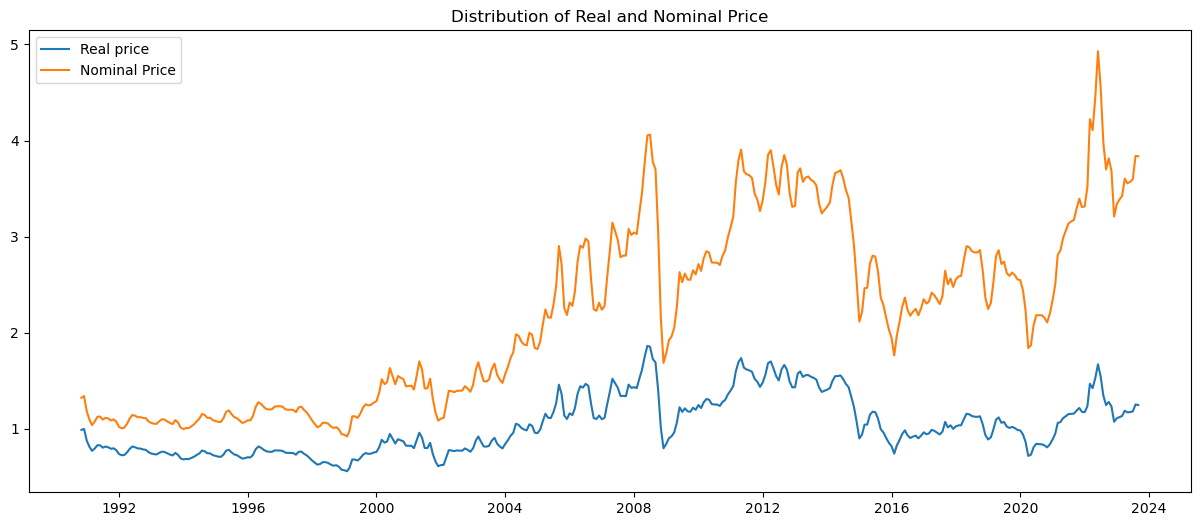

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(df['observation_date'], df['real_price'], label = 'Real price')
plt.plot(df['observation_date'], df['GASREGW'], label = 'Nominal Price')
plt.title('Distribution of Real and Nominal Price')
plt.legend()
plt.show();

In [ ]:
df.index = df.observation_date

In [ ]:
df.drop(columns = 'observation_date')

,GASREGW,CPIAUCSL,real_price
observation_date,,,
1990-11-01,1.324,133.700,0.990
1990-12-01,1.341,134.200,0.999
1991-01-01,1.180,134.700,0.876
1991-02-01,1.094,134.800,0.812
1991-03-01,1.040,134.800,0.772
...,...,...,...
2023-05-01,3.555,303.294,1.172
2023-06-01,3.571,303.841,1.175
2023-07-01,3.597,304.348,1.182


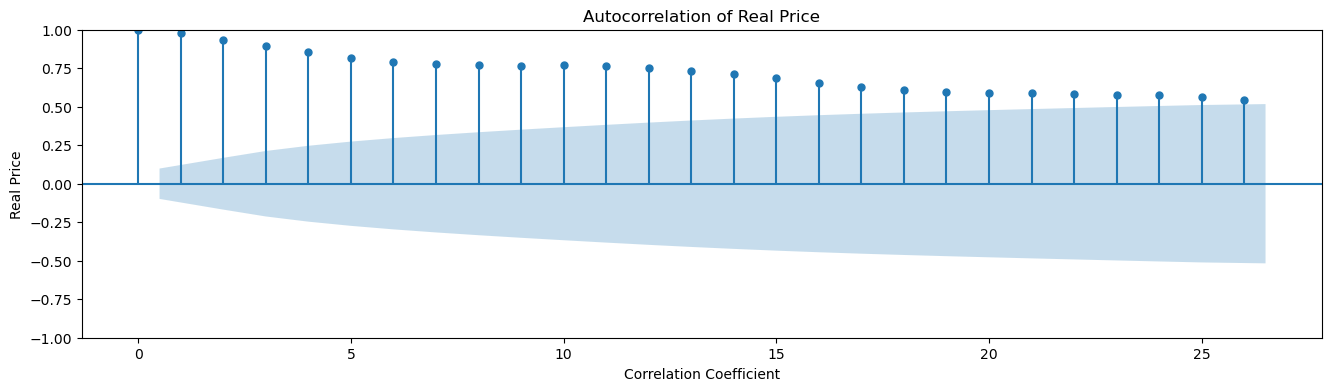

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_acf(df['real_price'], ax=ax)
# Add axis labels
plt.xlabel('Correlation Coefficient')
plt.ylabel('Real Price')
plt.title('Autocorrelation of Real Price');

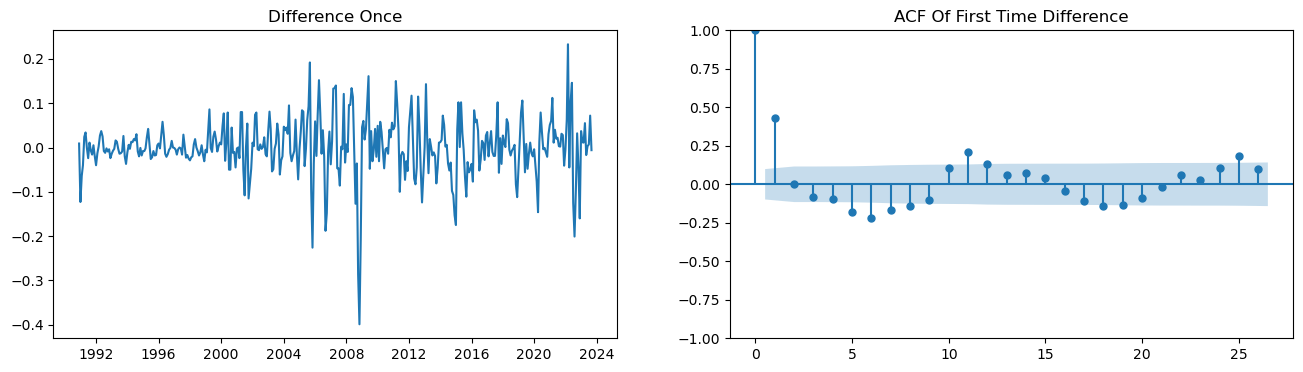

In [ ]:
dif = df.real_price.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(16,4))
ax1.plot(dif)
ax1.set_title('Difference Once')
plot_acf(dif, ax=ax2)
ax2.set_title('ACF Of First Time Difference');

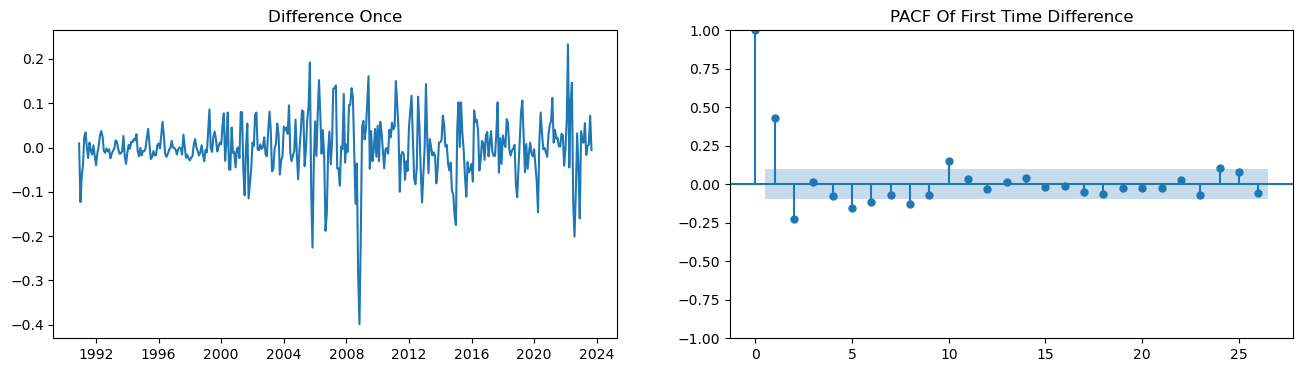

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(16,4))
ax1.plot(dif)
ax1.set_title('Difference Once')
plot_pacf(dif, ax=ax2)
ax2.set_title('PACF Of First Time Difference');

In [ ]:
dif.head()

observation_date
1990-12-01    0.009
1991-01-01   -0.123
1991-02-01   -0.064
1991-03-01   -0.040
1991-04-01    0.024
Name: real_price, dtype: float64

# AR Model for Real Price

In [ ]:
def wrangle_data(df):
    df.sort_index(ascending=True, inplace=True)

    # Return returns
    return df['real_price'].dropna()

In [ ]:
y_real = wrangle_data(df)

In [ ]:
y_real

observation_date
1990-11-01    0.990
1990-12-01    0.999
1991-01-01    0.876
1991-02-01    0.812
1991-03-01    0.772
              ...  
2023-05-01    1.172
2023-06-01    1.175
2023-07-01    1.182
2023-08-01    1.254
2023-09-01    1.248
Name: real_price, Length: 395, dtype: float64

## Split

In [ ]:
cutoff_test = int(len(y_real) * 0.90)
y_train = y_real.iloc[: cutoff_test]
y_test = y_real.iloc[cutoff_test :]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (355,)
y_test shape: (40,)


# Build AR Model Real Price

## Baseline

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean real Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean real Reading: 1.0169802816901412
Baseline MAE: 0.255773410037691


## Iterate

In [ ]:
real_model = AutoReg(y_train, lags=11, old_names=False)
real_ar = real_model.fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# AR model for First Difference

In [ ]:
cutoff_test = int(len(dif) * 0.90)
y_train = dif.iloc[: cutoff_test]
y_test = dif.iloc[cutoff_test :]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (354,)
y_test shape: (40,)


In [ ]:
diff_model = AutoReg(y_train, lags=11, old_names=False)
diff_ar = diff_model.fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# ARIMA Model for Real price
AR(1,1,0)

In [ ]:
cutoff_test = int(len(y_real) * 0.80)
y_train = y_real.iloc[: cutoff_test]
y_test = y_real.iloc[cutoff_test :]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (316,)
y_test shape: (79,)


In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean real Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean real Reading: 1.0178987341772159
Baseline MAE: 0.2786414837365809


In [ ]:
model = ARIMA(y_train, order= (1, 1, 0))
real_arima = model.fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
real_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             real_price   No. Observations:                  316
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 461.153
Date:                Sat, 09 Mar 2024   AIC                           -918.306
Time:                        16:56:27   BIC                           -910.801
Sample:                    11-01-1990   HQIC                          -915.307
                         - 02-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4702      0.029     15.940      0.000       0.412       0.528
sigma2         0.0031      0.000     20.012      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   4.59   Jarque-Bera (JB):               200.25
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               9.62   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA Model for First difference

AR(1,1,0)

### Split

In [ ]:
cutoff_test = int(len(dif) * 0.80)
y_train = dif.iloc[: cutoff_test]
y_test = dif.iloc[cutoff_test :]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (315,)
y_test shape: (79,)


## Baseline

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean real Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean real Reading: -0.00014603174603174617
Baseline MAE: 0.041931267321743515


In [ ]:
diff_model = ARIMA(y_train, order= (1, 1, 0))
diff_arima = diff_model.fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
diff_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             real_price   No. Observations:                  315
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 411.943
Date:                Sat, 09 Mar 2024   AIC                           -819.887
Time:                        16:56:27   BIC                           -812.388
Sample:                    12-01-1990   HQIC                          -816.890
                         - 02-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0763      0.038     -2.009      0.045      -0.151      -0.002
sigma2         0.0042      0.000     19.508      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               109.54
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               9.07   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA model for difference in Price

AR(0,1,1)

In [ ]:
diff_model = ARIMA(y_train, order= (0, 1, 1))
diff_arima1 = diff_model.fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
diff_arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             real_price   No. Observations:                  315
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 413.854
Date:                Sat, 09 Mar 2024   AIC                           -823.709
Time:                        16:56:27   BIC                           -816.210
Sample:                    12-01-1990   HQIC                          -820.712
                         - 02-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2532      0.037     -6.899      0.000      -0.325      -0.181
sigma2         0.0042      0.000     19.667      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   2.64   Jarque-Bera (JB):               116.31
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               9.42   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA model for difference in Price

AR(1,1,1)

In [ ]:
diff_model1 = ARIMA(y_train, order= (1, 1, 1))
diff_arima2 = diff_model1.fit()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
diff_arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             real_price   No. Observations:                  315
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 456.948
Date:                Sat, 09 Mar 2024   AIC                           -907.896
Time:                        16:56:28   BIC                           -896.648
Sample:                    12-01-1990   HQIC                          -903.401
                         - 02-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4734      0.033     14.249      0.000       0.408       0.538
ma.L1         -1.0000      2.642     -0.378      0.705      -6.178       4.178
sigma2         0.0031      0.008      0.376      0.707      -0.013       0.020
===================================================================================
Ljung-Box (L1) (Q):                   4.45   Jarque-Bera (JB):               206.97
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               9.65   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Comparing the summary statistics and our Basline Mean Absolute Error(MAE), ARIMA(1,1,1) proves to be the best so we will be performing our Forcast on that Model.

In [ ]:
step = 32

fc= diff_arima2.forecast(step)
fc = pd.Series(fc, index=y_test[:step].index)
fc

observation_date
2017-03-01   -0.009560
2017-04-01   -0.004619
2017-05-01   -0.002279
2017-06-01   -0.001172
2017-07-01   -0.000648
2017-08-01   -0.000400
2017-09-01   -0.000282
2017-10-01   -0.000226
2017-11-01   -0.000200
2017-12-01   -0.000188
2018-01-01   -0.000182
2018-02-01   -0.000179
2018-03-01   -0.000178
2018-04-01   -0.000177
2018-05-01   -0.000177
2018-06-01   -0.000177
2018-07-01   -0.000177
2018-08-01   -0.000177
2018-09-01   -0.000176
2018-10-01   -0.000176
2018-11-01   -0.000176
2018-12-01   -0.000176
2019-01-01   -0.000176
2019-02-01   -0.000176
2019-03-01   -0.000176
2019-04-01   -0.000176
2019-05-01   -0.000176
2019-06-01   -0.000176
2019-07-01   -0.000176
2019-08-01   -0.000176
2019-09-01   -0.000176
2019-10-01   -0.000176
Name: predicted_mean, dtype: float64

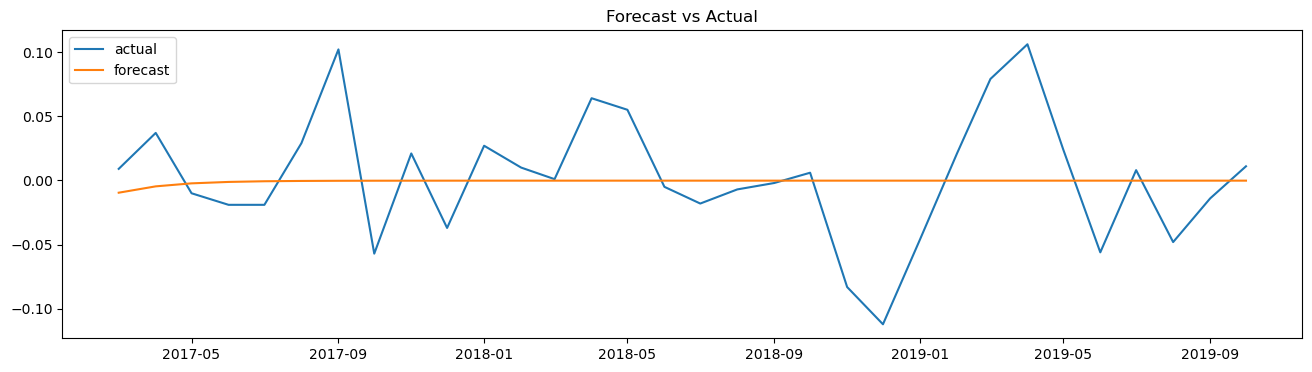

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(y_test[:step], label ='actual')
plt.plot(fc, label='forecast')
plt.title("Forecast vs Actual")
plt.legend(loc='upper left')

We observe that our Forecast closely follows the trend which shows that the model performs well

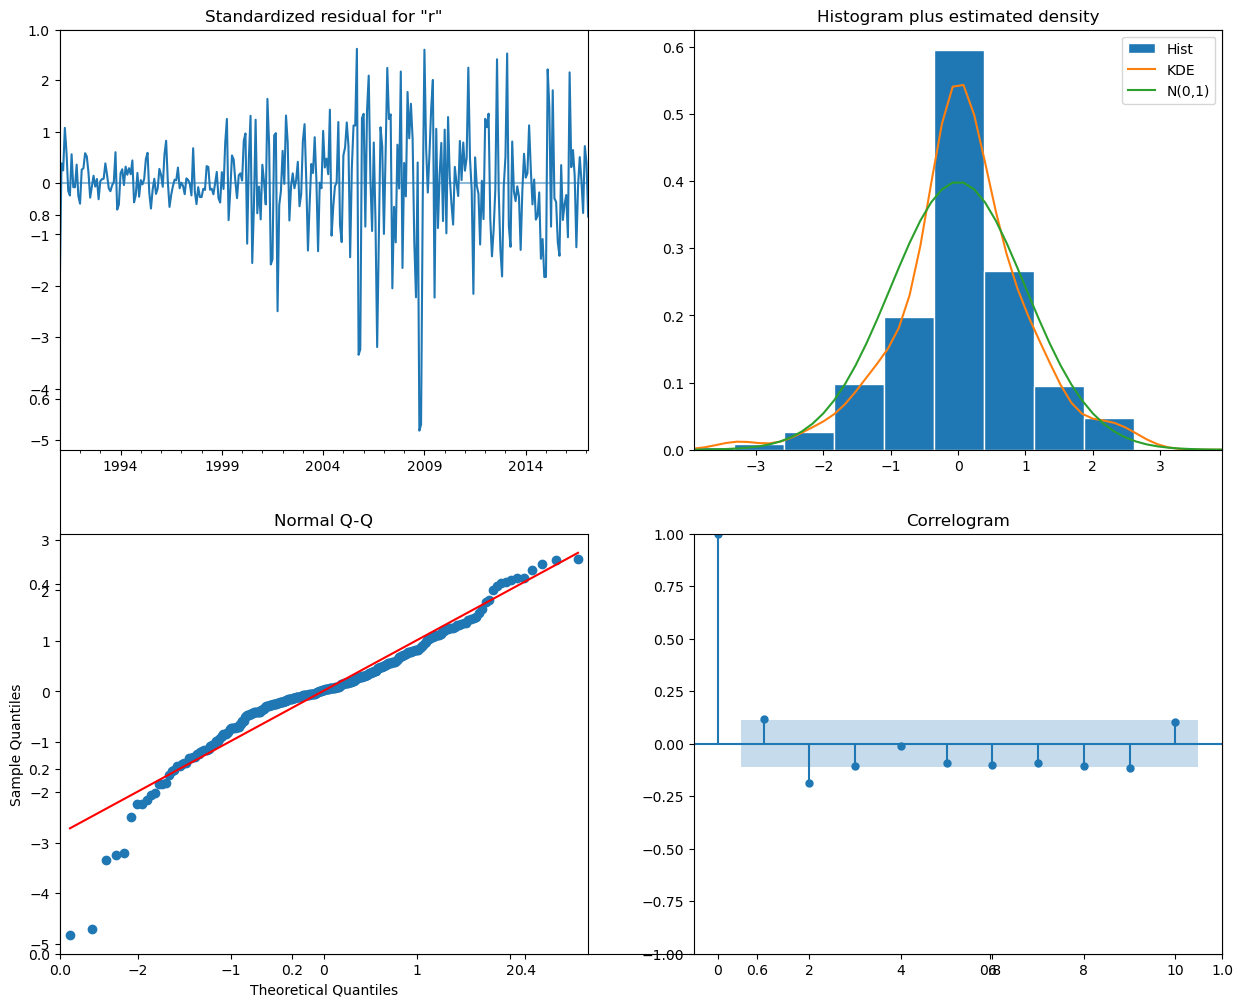

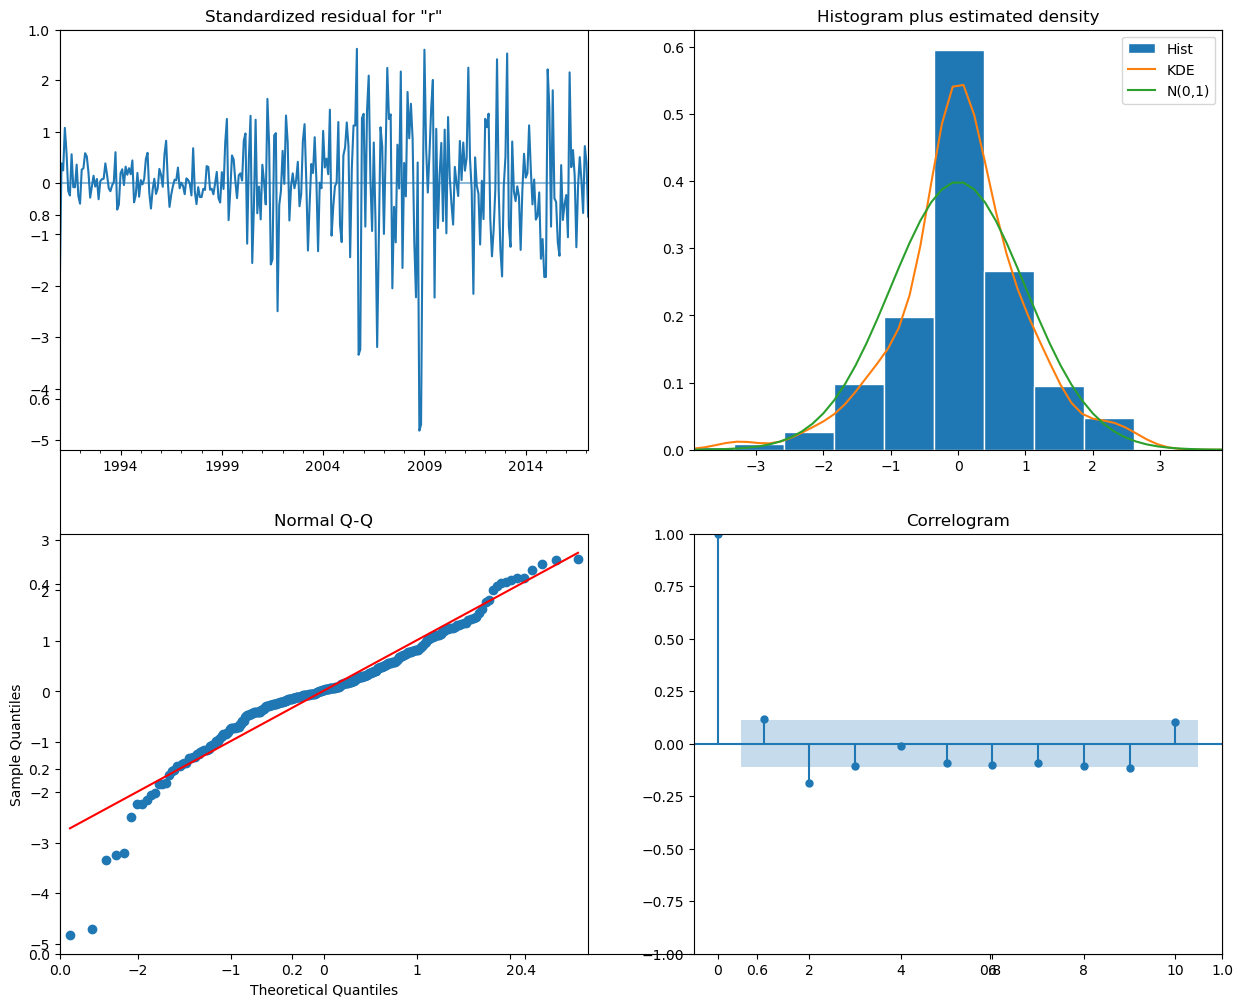

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
diff_arima2.plot_diagnostics(fig=fig)

Creating a walk-forward validation to validate our predictions

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(1, 1, 1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 0.05


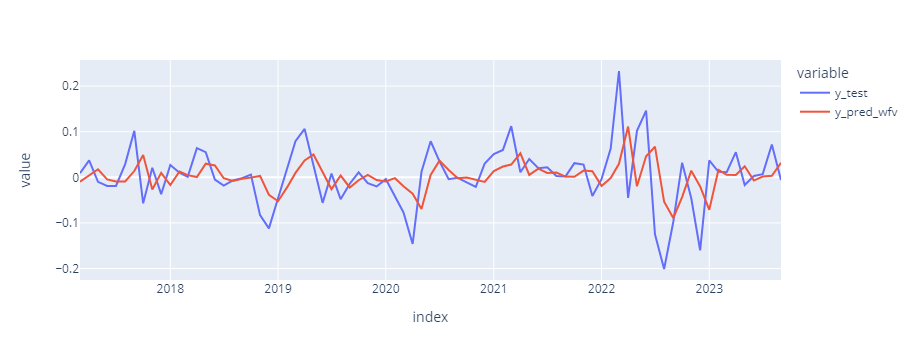

In [ ]:
df_predictions = pd.DataFrame({'y_test': y_test, 'y_pred_wfv': y_pred_wfv})
fig = px.line(df_predictions,labels={'values': 'dif'})
fig.show()